# CNN architecture Pythorch

- add scheduler
- add optimizer 
- add metric from pytorch baseline
- change kernel size (5,1)

- stratified KFold


In [1]:
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import platform
plt.style.use('seaborn')
from datetime import datetime
import json
from sklearn.model_selection import KFold, GroupKFold, train_test_split
from tqdm import tqdm

# from metric import E1_loss, E2_loss, total_loss
# from models import classifier, cnn_model, conv_block, cnn_parallel
# from utils import train_model, eval_model, dfDataset, weights_init

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torchsummary import summary



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Helper functions

In [2]:
def fix_seed(SEED):
    torch.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(SEED)



class Noise(object):
    def __init__(self, mu, sd, shape):
        self.mu = mu
        self.sd = sd
        self.shape = shape
    
    def __call__(self, x):
        noise = np.random.normal(self.mu, self.sd, self.shape)
        #noise = torch.FloatTensor(noise)
        return x + noise.astype(np.float32)

class dfDataset(Dataset):
    def __init__(self, x, y, transform = None):
        self.data = x
        self.target = y
        self.transform = transform
    
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, index):
        batchX, batchY = self.data[index], self.target[index]
        if self.transform:
            batchX = self.transform(batchX)
        return batchX, batchY
    
def weights_init(m, initializer = nn.init.kaiming_uniform_):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        initializer(m.weight)
    

class conv_bn(nn.Module):
    def __init__(self, i_f, o_f, fs):
        super(conv_bn, self).__init__()
        self.conv = nn.Conv2d(i_f, o_f, fs)
        self.act = nn.ELU()
        self.bn = nn.BatchNorm2d(o_f)
        self.pool = nn.MaxPool2d(kernel_size=(2, 1), stride= (2, 1))
    def forward(self, x):
        x = self.bn(self.act(self.conv(x)))
        return self.pool(x)  #return x
    

class conv_block(nn.Module):
    def __init__(self, h_list, input_shape, fs):
        '''
        input_shape : not include batch_size
        '''
        
        super(conv_block, self).__init__()
        self.input_shape = input_shape
        self.fs = fs
        convs = []
        for i in range(len(h_list)):
            if i == 0:
                convs.append(conv_bn(self.input_shape[0], h_list[i], fs))
            else:
                convs.append(conv_bn(h_list[i-1], h_list[i], fs))
        self.convs = nn.Sequential(*convs)
    
    def forward(self, x):
        return self.convs(x)
    

class classifier(nn.Module):
    def __init__(self, h_list, input_size, output_size):
        super(classifier, self).__init__()
        layers = []
        for i in range(len(h_list)):
            if i == 0:
                layers.append(nn.Linear(input_size, h_list[0]))
            else:
                layers.append(nn.Linear(h_list[i-1], h_list[i]))
            layers.append(nn.ELU())
            
        layers.append(nn.Linear(h_list[i], output_size))
        self.layers = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.layers(x)
    
class cnn_model(nn.Module):
    def __init__(self, cnn_block, fc_block):
        super(cnn_model, self).__init__()
        self.cnn = cnn_block
        self.fc = fc_block
    def forward(self, x):
        x = self.cnn(x)
        x = x.flatten(start_dim = 1)
        return self.fc(x)


def E1_loss(y_pred, y_true):
    _t, _p = y_true, y_pred
    return torch.mean(torch.mean((_t - _p) ** 2, axis = 1)) / 2e+04


def E2_loss(y_pred, y_true):
    _t, _p = y_true, y_pred    
    return torch.mean(torch.mean((_t - _p) ** 2 / (_t + 1e-06), axis = 1))

In [3]:
class custom_cnn(nn.Module):
    def __init__(self, k_=(4,1)):
        super(custom_cnn, self).__init__()
        self.fe = nn.Sequential(
            nn.Conv2d(in_channels=2, out_channels=16, kernel_size=k_, stride=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size = (2,1)),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=k_, stride=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size = (2,1)),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=k_, stride=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size = (2,1)),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=k_, stride=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size = (2,1)),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=k_, stride=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size = (2,1)),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=k_, stride=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size = (2,1))
        )
    def forward(self, x):
        return self.fe(x)

In [4]:
class custom_fc(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(custom_fc, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.fc(x)

In [5]:
def normalize(x, axis = 2):
    mu = np.expand_dims(x.mean(axis = 2), axis = axis)
    sd = np.expand_dims(x.std(axis = 2), axis = axis)

    normalized = (x - mu) / sd
    return normalized

In [15]:
import random
from collections import Counter, defaultdict

def stratified_group_k_fold(X, y, groups, k, seed=None):
    
    """ https://www.kaggle.com/jakubwasikowski/stratified-group-k-fold-cross-validation """

    labels_num = np.max(y) + 1
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)
    for g, y_counts in tqdm(sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])), total=len(groups_and_y_counts)):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices



In [7]:
def kaeri_score(y_true, y_pred):
    if train_target == 'xy':
        return E1_loss(y_true, y_pred)
    elif train_target == 'mv':
        return E2_loss(y_true, y_pred)
    else:
        return 0.5 * E1_loss(y_true, y_pred) + 0.5 * E2_loss(y_true, y_pred)


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
class KaeriMeter(object):
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.y_true = np.array([0,0,0,0])
        self.y_pred = np.array([0.5,0.5,0.5,0.5])
        self.score = 0
        
    def update(self, y_true, y_pred):

        self.y_true = y_true.detach().cpu()
        self.y_pred = y_pred.detach().cpu()
        
        self.score = kaeri_score(self.y_true, self.y_pred)
    
    @property
    def avg(self):
        return self.score

In [8]:
def train_model(model, train_data, weight, optimizer, loss_func):
    model.train()
    final_scores = KaeriMeter()
    loss_sum = 0
    for i, (x, y) in enumerate(train_data):
        optimizer.zero_grad()
        x = x.cuda()
        y = y.cuda()
        pred = model(x)
        loss = loss_func(pred, y)
        loss.backward()
        final_scores.update(y, pred)
        optimizer.step()
        loss_sum += loss.item()
    
    return (loss_sum / len(train_data)), final_scores

def eval_model(model, val_data, loss_func):
    model.eval()

    final_scores = KaeriMeter()

    with torch.no_grad():
        loss = 0
        for i, (x, y) in enumerate(val_data):
            x = x.cuda()
            y = y.cuda()
            pred = model(x)
            loss += loss_func(pred, y).item()
            final_scores.update(y, pred)

    return (loss / len(val_data)), final_scores

# Master Params


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [10]:
COLAB = True

SEED = 34
fix_seed(SEED)

# now = datetime.strftime(datetime.now(), '%Y%m%d-%H%M%S')
save_path = '/content/drive/My Drive/ML Projects/DACON/Colision/models_torch_4'      # './model/{}'.format(now)

initialize = True
print_summary = True

nfold = 5
batch_size = 256
EPOCH = 200
base_lr = 0.001

# Load dataset

In [11]:
if COLAB:
    root_dir = '/content/drive/My Drive/ML Projects/DACON/Colision/data/'  
# else: root_dir = 'D:/datasets/KAERI_dataset/'


train_f = pd.read_csv(os.path.join(root_dir, 'train_features.csv'))
train_t = pd.read_csv(os.path.join(root_dir, 'train_target.csv'))
test_f = pd.read_csv(os.path.join(root_dir, 'test_features.csv'))

train_f = train_f[['Time','S1','S2','S3','S4']].values.reshape((-1, 1, 375, 5))#.astype(np.float32)

test_f = test_f[['Time','S1','S2','S3','S4']].values.reshape((-1, 1, 375, 5))#.astype(np.float32)


# concatenate normalized data
train_norm = normalize(train_f)
test_norm = normalize(test_f)

train_f = np.concatenate((train_f, train_norm), axis = 1)
test_f = np.concatenate((test_f, test_norm), axis = 1)

test_f = torch.FloatTensor(test_f)

In [12]:
train_f.shape

(2800, 2, 375, 5)

In [13]:
# make SKF groups

def get_stratify_group(row):
    stratify_group = f'_{row["M"]}'
    stratify_group += f'_{row["V"]}'
    return stratify_group

def get_labels(row):
    labels = f'{row["X"]}'
    labels += f',{row["Y"]}'
    labels += f',{row["M"]}'
    labels += f',{row["V"]}'
    return labels



df_folds = train_t.copy()
df_folds = df_folds.sample(frac=1).reset_index(drop=True)

df_folds['groups'] = df_folds.apply(get_stratify_group, axis=1)
df_folds['groups'] = df_folds['groups'].astype('category').cat.codes

df_folds['labels'] = df_folds.apply(get_labels, axis=1)

df_folds.head()

,id,X,Y,M,V,groups,labels
0,2195,0.0,300.0,125.0,0.4,6,"0.0,300.0,125.0,0.4"
1,1994,300.0,200.0,100.0,0.6,2,"300.0,200.0,100.0,0.6"
2,1410,300.0,300.0,150.0,0.4,11,"300.0,300.0,150.0,0.4"
3,2648,400.0,200.0,100.0,0.6,2,"400.0,200.0,100.0,0.6"
4,1205,400.0,-300.0,75.0,0.4,31,"400.0,-300.0,75.0,0.4"


In [ ]:
df_folds.loc[:, 'fold'] = 0

skf = stratified_group_k_fold(X=df_folds.index, 
                              y=df_folds['groups'], 
                              groups=df_folds['id'], k=5, seed=SEED)

for fold_number, (train_index, val_index) in enumerate(tqdm(skf)):
    df_folds.loc[df_folds.iloc[val_index].index, 'fold'] = fold_number

In [17]:
df_folds.head()

,id,X,Y,M,V,groups,labels,fold
0,2195,0.0,300.0,125.0,0.4,6,"0.0,300.0,125.0,0.4",1
1,1994,300.0,200.0,100.0,0.6,2,"300.0,200.0,100.0,0.6",0
2,1410,300.0,300.0,150.0,0.4,11,"300.0,300.0,150.0,0.4",3
3,2648,400.0,200.0,100.0,0.6,2,"400.0,200.0,100.0,0.6",1
4,1205,400.0,-300.0,75.0,0.4,31,"400.0,-300.0,75.0,0.4",0


In [20]:
df_folds.fold.nunique()

5

In [ ]:
df_folds.fold.nunique()

In [26]:
for (train_idx, val_idx) in tqdm(skf):
        
        trainx, valx = train_f[train_idx], train_f[val_idx]
        trainy, valy = train_t[train_idx], train_t[val_idx]

        print(trainx.shape, valx.shape)


0it [00:00, ?it/s]


In [25]:
skf

<generator object stratified_group_k_fold at 0x7f700732bfc0>

# Train

In [16]:
def kfold_train(name, feature, target):

    kf = KFold(nfold, shuffle=True, random_state=SEED)
    os.makedirs(save_path) if not os.path.exists(save_path) else None
    print('> {} train...'.format(name))

    # make dataset
    n_features = feature.shape[-1]
    train_target = target[list(name)].values
    noise_add = Noise(0, 0.001, feature.shape[1:])
    loss_per_cv = []
    
    for i, (train_idx, val_idx) in enumerate(kf.split(feature, y = train_target)):
        
        print('-'*10)
        print('fold {}/{}'.format(i+1, nfold))
        print('-'*10)

        trainx, valx= feature[train_idx], feature[val_idx]
        trainy, valy= train_target[train_idx], train_target[val_idx]

        train_loader = DataLoader(
            dfDataset(trainx.astype(np.float32), trainy, transform=noise_add), batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(
            dfDataset(valx.astype(np.float32), valy), batch_size=batch_size, shuffle=True)
        
        # model
        fe = custom_cnn()
        fc = custom_fc(input_dim=512*2*n_features, output_dim=len(name))
        model = nn.Sequential(fe, fc)
      
        optimizer = torch.optim.Adam(model.parameters(), lr=base_lr)

        if name == 'XY':
            criterion = E1_loss
        else:
            criterion = E2_loss

        model = model.cuda()
        if initialize:
            model.apply(weights_init)

        curr_loss = 1e+7
        
        # Train
        for ep in range(1, EPOCH + 1):
            loss, scores_train = train_model(model, train_loader, criterion, optimizer, criterion)
            val_loss, scores_val = eval_model(model, val_loader, criterion)
            
            if curr_loss > val_loss:
                print('[{}] train loss: {:4f}, train_score: {:.5f}, val loss drop: {:.4f} to: {:.4f}, val_score: {:.5f}'.format(ep, np.mean(loss), scores_train.avg, curr_loss, val_loss, scores_val.avg))
                
                curr_loss = val_loss
                torch.save(model.state_dict(), os.path.join(save_path, 'model_{}_fold{}.pt'.format(name, i+1)))
        loss_per_cv.append(curr_loss)
    return loss_per_cv           

In [17]:
# train XY
loss_xy = kfold_train('XY',train_f, train_t)

add_feature = train_t[['X','Y']].values.reshape((2800, 1, 1, 2))
add_feature = np.repeat(add_feature, 375, axis = 2)
add_feature = np.repeat(add_feature, 2, axis = 1)
trainX = np.concatenate((train_f, add_feature), axis = -1)

# train V using XY
loss_v = kfold_train('V',trainX, train_t)

add_feature = train_t[['V']].values.reshape((2800, 1, 1, 1))
add_feature = np.repeat(add_feature, 375, axis = 2)
add_feature = np.repeat(add_feature, 2, axis = 1)
trainX = np.concatenate((trainX, add_feature), axis = -1)

# train M using.. 
loss_m = kfold_train('M',trainX, train_t)

> XY train...
----------
fold 1/5
----------
[1] : train loss: 2.722458, val loss drop: 10000000.0000 to: 1.5495
[2] : train loss: 0.781087, val loss drop: 1.5495 to: 0.3483
[3] : train loss: 0.239417, val loss drop: 0.3483 to: 0.1666
[4] : train loss: 0.089852, val loss drop: 0.1666 to: 0.0969
[5] : train loss: 0.039067, val loss drop: 0.0969 to: 0.0477
[6] : train loss: 0.024801, val loss drop: 0.0477 to: 0.0429
[7] : train loss: 0.013968, val loss drop: 0.0429 to: 0.0125
[8] : train loss: 0.009092, val loss drop: 0.0125 to: 0.0100
[9] : train loss: 0.007064, val loss drop: 0.0100 to: 0.0089
[10] : train loss: 0.004731, val loss drop: 0.0089 to: 0.0054
[11] : train loss: 0.003910, val loss drop: 0.0054 to: 0.0050
[12] : train loss: 0.002779, val loss drop: 0.0050 to: 0.0039
[14] : train loss: 0.002637, val loss drop: 0.0039 to: 0.0035
[17] : train loss: 0.003059, val loss drop: 0.0035 to: 0.0034
[18] : train loss: 0.002204, val loss drop: 0.0034 to: 0.0032
[19] : train loss: 0.001889

In [18]:
loss_per_model = {'xy':loss_xy, 'v':loss_v, 'm':loss_m}
with open(os.path.join(save_path, 'loss_info.json'), 'w') as f:
    for k in loss_per_model:
        loss_per_model[k] = np.mean(loss_per_model[k])
    f.write(json.dumps(loss_per_model))

In [19]:
loss_per_model

{'m': 0.015528180976863018,
 'v': 0.0005324836457697251,
 'xy': 0.0003994177532988942}

In [ ]:
loss_per_model # leaky relu

{'xy': 0.000625143100911778,
 'v': 0.0010803749855117096,
 'm': 0.02109942916598308}

In [ ]:
loss_per_model #elu

{'xy': 0.000880345263100234,
 'v': 0.0009727095718393787,
 'm': 0.01579595682751895}

In [ ]:
loss_per_model # relu

{'xy': 0.0006840781165308819,
 'v': 0.0010359705444652266,
 'm': 0.023326632654456333}

- xy : leakyrelu > relu > elu
- v : elu > relu > leakyrelu
- m : elu > leakyrelu > relu

# Predict Test set

In [20]:
def predict_fold(model,nfold, save_path, name, test_data):
    pred_array = []
    for i in range(1, nfold+1):
        model.load_state_dict(torch.load(os.path.join(save_path, 'model_{}_fold{}.pt'.format(name, i))))
        model = model.cuda()
        
        with torch.no_grad():
            predict = model(test_data.cuda())
        pred_array.append(predict.detach().cpu().numpy())
    result = np.mean(pred_array, axis = 0)
    return result

In [21]:
submission = pd.read_csv(os.path.join(root_dir, 'sample_submission.csv'))
submission.head()

,id,X,Y,M,V
0,2800,0,0,0,0
1,2801,0,0,0,0
2,2802,0,0,0,0
3,2803,0,0,0,0
4,2804,0,0,0,0


In [23]:
# predict XY
name = 'XY'
n_features = test_f.size()[-1]

# define model
fe = custom_cnn()
fc = custom_fc(512*2*n_features, len(name))
model = nn.Sequential(fe, fc)

result = predict_fold(model, nfold, save_path ,name, test_f)
submission[list(name)] = result

In [24]:
n_samples = test_f.shape[0]
add_feature_t = result.reshape((n_samples, 1, 1, len(name)))
add_feature_t = np.repeat(add_feature_t, 375, axis = 2)
add_feature_t = np.repeat(add_feature_t, 2, axis = 1)
add_feature_t = torch.FloatTensor(add_feature_t)

test_f_add = torch.cat([test_f, add_feature_t], dim = -1)

In [26]:
# predict V
name = 'V'
n_features = test_f_add.size()[-1]
# define model
fe = custom_cnn()
fc = custom_fc(512*2*n_features, len(name))
model = nn.Sequential(fe, fc)

result = predict_fold(model, nfold, save_path,name, test_f_add)
submission[list(name)] = result

In [27]:
n_samples = test_f_add.shape[0]
add_feature_t = result.reshape((n_samples, 1, 1, len(name)))
add_feature_t = np.repeat(add_feature_t, 375, axis = 2)
add_feature_t = np.repeat(add_feature_t, 2, axis = 1)
add_feature_t = torch.FloatTensor(add_feature_t)

test_f_add = torch.cat([test_f_add, add_feature_t], dim = -1)

In [28]:
# predict M
name = 'M'
n_features = test_f_add.size()[-1]
# define model

fe = custom_cnn()
fc = custom_fc(512*2*n_features, len(name))
model = nn.Sequential(fe, fc)

result = predict_fold(model, nfold, save_path,name, test_f_add)
submission[list(name)] = result

In [29]:
submission.head()

,id,X,Y,M,V
0,2800,-267.242706,-43.292133,112.838829,0.477926
1,2801,313.012604,-284.765137,92.048500,0.502950
2,2802,-233.707474,131.553925,30.877136,0.399649
3,2803,159.488724,266.318665,28.779810,0.426692
4,2804,-158.615936,187.226364,132.042160,0.493310


In [30]:
submission.to_csv(os.path.join(save_path, 'submission_torch3.csv'), index=False)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6220f21a90>,
      dtype=object)

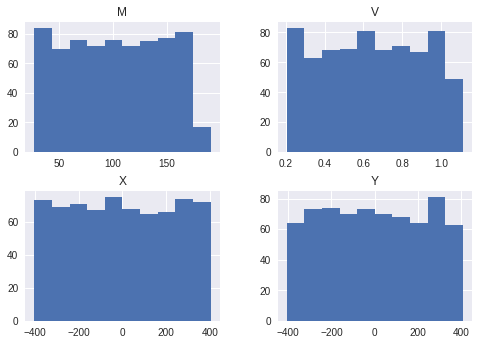

In [32]:
submission.iloc[:, 1:].hist()